**NOMS I COGNOMS:** Junjie Li, Manuel Liu Wang, Leying Wang

**GRUP DE LABORATORI:** A

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [134]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes


In [135]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq


In [136]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


In [137]:
YEARS = [2019, 2020, 2021]


Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [138]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)):
            urllib.request.urlretrieve(
                f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')


  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [139]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [140]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']


def clean_data(data, year, month, sampling=1000):
    """
    Funció que neteja les dades per un mes donat.
    """

    dataset = load_table(year, month)[required_data]
    dataset = dataset[::sampling]

    # Les dades s'importen per mes i any. Les dates són correctes?
    anyCorrecte_pick = pd.DatetimeIndex(dataset['tpep_pickup_datetime']).year == year
    mesCorrecte_pick = pd.DatetimeIndex(dataset['tpep_pickup_datetime']).month == month
    anyCorrecte_drop = pd.DatetimeIndex(dataset['tpep_dropoff_datetime']).year == year
    mesCorrecte_drop = pd.DatetimeIndex(dataset['tpep_dropoff_datetime']).month == month
    dataset = dataset[(anyCorrecte_pick & mesCorrecte_pick) & (anyCorrecte_drop & mesCorrecte_drop)]

    # La recollida és després que la finalització del trajecte.
    dataset = dataset[dataset['tpep_dropoff_datetime'] > dataset['tpep_pickup_datetime']]

    # Viatges amb 0 passatgers?
    dataset = dataset[dataset['passenger_count'] > 0]

    # Viatges molts llargs o molt curts?
    dataset = dataset[dataset['trip_distance'] > 0]

    # Pagaments negatius.
    dataset = dataset[dataset['total_amount'] > 0]
    dataset = dataset[dataset['fare_amount'] > 0]

    # location filter
    location = (dataset['PULocationID'] > 0) & (dataset['PULocationID'] < 264) & (dataset['DOLocationID'] > 0) & (dataset['DOLocationID'] < 264)
    dataset = dataset[location]


    return dataset


A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [141]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    data = data[required_data]

    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year

    data['pickup_hour'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).hour
    data['pickup_day'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).dayofweek
    data['pickup_week'] =  pd.Int64Index(pd.DatetimeIndex(data['tpep_dropoff_datetime']).isocalendar().week)
    data['pickup_month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
    data['pickup_dayofyear'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).dayofyear

    data['dropoff_hour'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).hour
    data['dropoff_day'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).dayofweek
    data['dropoff_week'] =  pd.Int64Index(pd.DatetimeIndex(data['tpep_dropoff_datetime']).isocalendar().week)
    data['dropoff_month'] = pd.DatetimeIndex(data['tpep_dropoff_datetime']).month

    data['trip_duration'] = (data['tpep_dropoff_datetime'] -  data['tpep_pickup_datetime']).astype('timedelta64[s]')/3600
    data['trip_distance'] = data['trip_distance'] / 1.6 # miles a km
    data['mean_speed'] = data['trip_distance']/data['trip_duration']


    return data


Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [142]:
df = pd.concat([clean_data(load_table(year, month), year, month, 1000) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave=False)])


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [143]:
df = post_processing(df)
df


C:\Users\JUNJIE_LI\AppData\Local\Temp\ipykernel_16792\3380611355.py:11: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  data['pickup_week'] =  pd.Int64Index(pd.DatetimeIndex(data['tpep_dropoff_datetime']).isocalendar().week)
C:\Users\JUNJIE_LI\AppData\Local\Temp\ipykernel_16792\3380611355.py:17: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  data['dropoff_week'] =  pd.Int64Index(pd.DatetimeIndex(data['tpep_dropoff_datetime']).isocalendar().week)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,1,1,1,1,0,1,1,1,0.111111,8.437500
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,1,0.135278,8.824435
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,0.87500,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,1,0.140833,6.213018
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.41875,162,137,2,4.0,5.30,2019,...,1,1,1,1,0,1,1,1,0.050000,8.375000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,1.69375,161,262,1,13.5,17.76,2019,...,1,1,1,1,0,1,1,1,0.288611,5.868624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106000,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,0.62500,107,170,1,5.5,11.15,2021,...,4,52,12,365,22,4,52,12,0.075833,8.241758
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.02500,211,158,2,9.0,12.80,2021,...,4,52,12,365,22,4,52,12,0.161111,6.362069
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,0.93125,79,164,2,8.0,11.80,2021,...,4,52,12,365,23,4,52,12,0.161389,5.770224
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.56250,263,236,1,5.0,11.00,2021,...,4,52,12,365,23,4,52,12,0.057778,9.735577


In [144]:
df.head(2)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,1,1,1,1,0,1,1,1,0.111111,8.437500
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,1,0.135278,8.824435


## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [145]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    
    df[column].value_counts(sort=False).plot.bar(title=title, xlabel=xlabel, ylabel=ylabel)


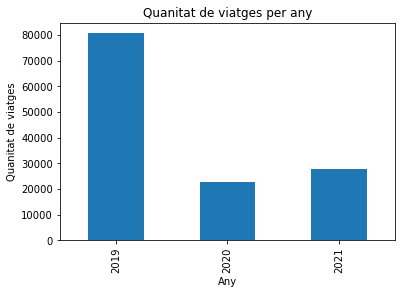

In [146]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')


**Pregunta: És el comportament que esperàveu? Per què?**

> ANSWER

     Sí. Podem veure a partir del diagram de barres, que els viatges realitzats a l'any 2020, i 2021 va disminuir molt comparant amb els de l'any 2019, de manera que podem  confirmar que la pandèmia va afectar a la quantitat de viatges fets amb taxis.

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [147]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm=False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """

    df[['passenger_count', 'year']].groupby(['year']).value_counts(normalize=norm).to_frame().unstack(level=0).plot(
        kind='bar', subplots=True, layout=(1, 3), figsize=(20,5), ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=YEARS)


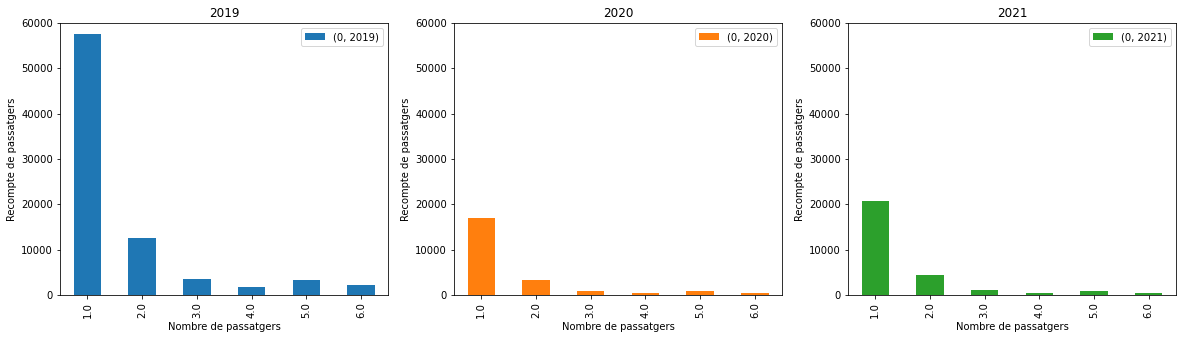

In [148]:
passengers_taxi_year(df, (0, 60000), 'Nombre de passatgers','Recompte de passatgers', 'Recompte de passatgers per any')


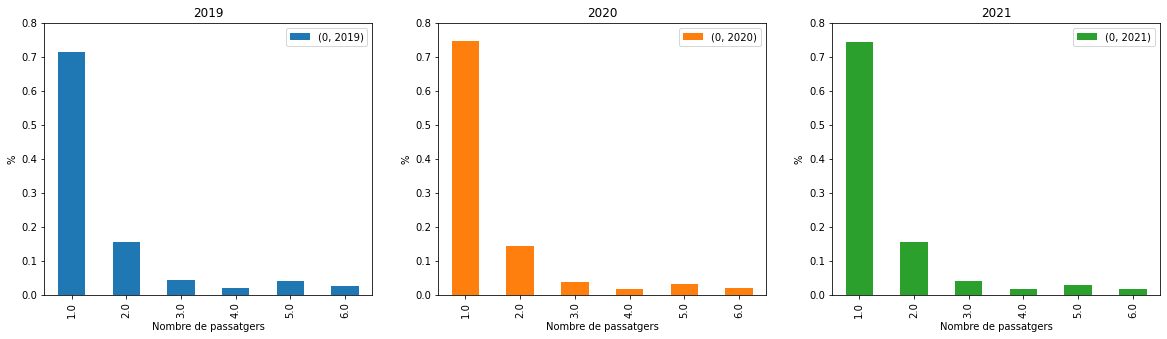

In [149]:
passengers_taxi_year(df, (0, 0.8), 'Nombre de passatgers','%', '% de passatgers per any', norm=True)


A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [150]:
def passengers_taxi(df, xlabel, ylabel, norm=False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """

    df[['passenger_count', 'year']].groupby(['year']).value_counts(normalize=norm).to_frame().unstack(level=0).plot(
        kind = 'bar', xlabel = xlabel, ylabel = ylabel, title = 'Nombre de passatgers')


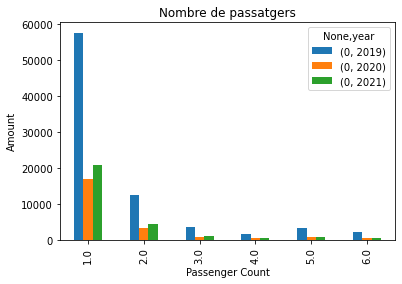

In [151]:
passengers_taxi(df, 'Passenger Count', 'Amount')


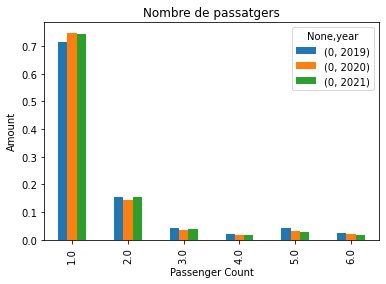

In [152]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm=True)


**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

> ANSWER :

    Podem vuere que els viatges que s'han realitzat durant el període de la pandèmia ha disminuït de forma notòria respecte els altres anys. I el 2021 ha tornat a augmentar. A apart d'això, podem veure que a causa de l'implantació de les restriccions sanitàries, el percentatge d'anar només 1 passatger al taxi és molt més alt en els anys 2020 i 2021.

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [153]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """

    fig, ax = plt.subplots(1, 2, figsize=(20,5)) 
    fig.suptitle(title)
    
    # fem el recompte de la quantitat de viatges dels 3 anys per pickup i dropoff repectivament
    for column in range(len(columns)):
        df.groupby([columns[column]]+['year'])[columns[column]].count().to_frame().unstack().plot(kind='line', ax=ax[column], style='o:',legend=YEARS, xlabel=xlabel, ylabel=ylabel)
    


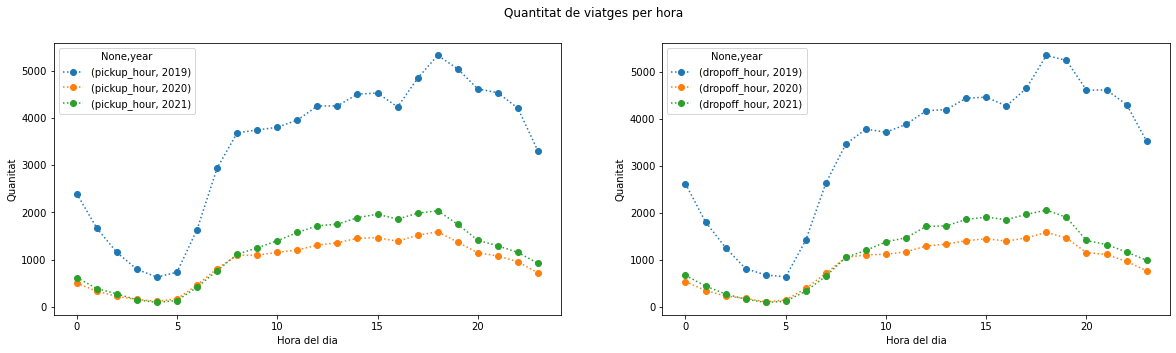

In [154]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title='Quantitat de viatges per hora', xlabel='Hora del dia', ylabel='Quanitat')


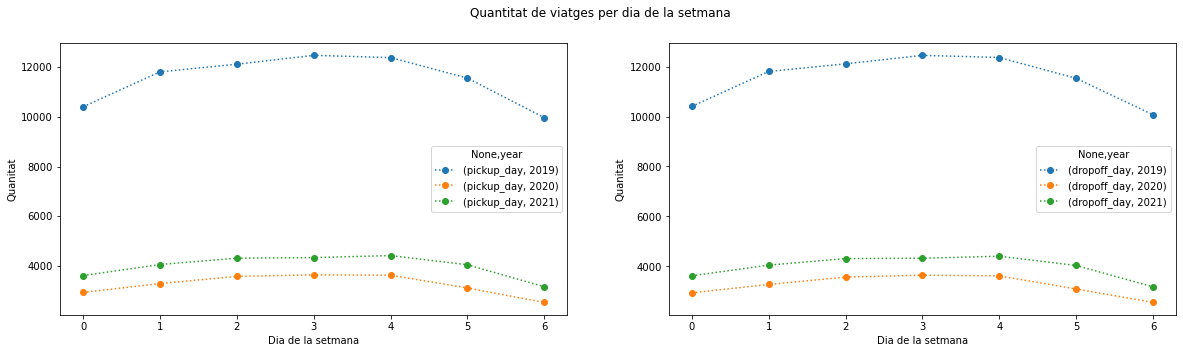

In [155]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title='Quantitat de viatges per dia de la setmana', xlabel='Dia de la setmana', ylabel='Quanitat')


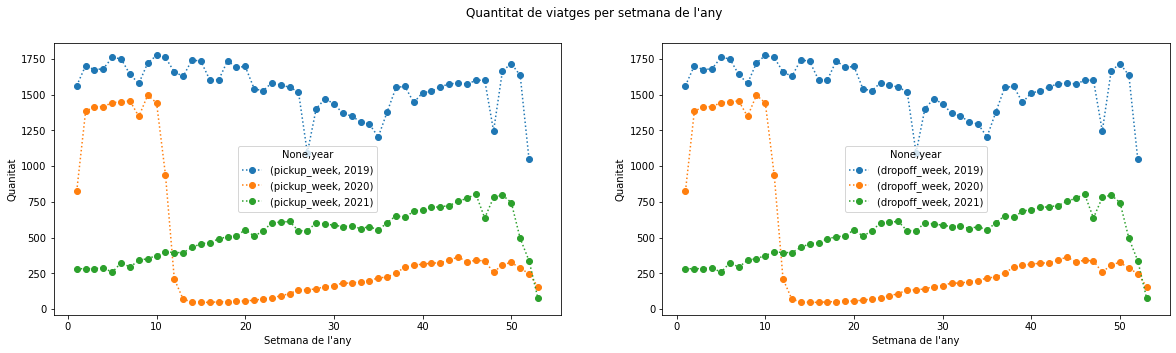

In [157]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title='Quantitat de viatges per setmana de l\'any', xlabel='Setmana de l\'any', ylabel='Quanitat')


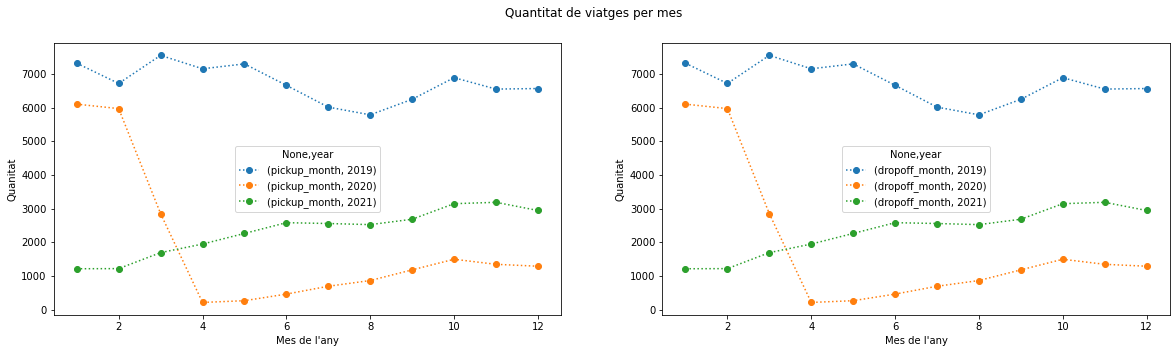

In [158]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title='Quantitat de viatges per mes', xlabel='Mes de l\'any', ylabel='Quanitat')


**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

> ANSWER
> > A partir de les gràfiques de línies organitzades segons la hora del dia, el dia de la setmana, setmana de l'any, i mes de l'any podem deduir que:
    
    1. Quantitat de viatges per hora: els rangs d'hores en les quals es realitzen més viatges són, d'entre 8:00-21:00, podrem observar que hi ha un gran canvi a partir de les 8.00, que és quan la gent va al treball, i a les 18:00, que és quan la gent surt de la feina.
    2.De la quantitat de viatges que s'han realitzat en dies de la setmana podrem veure que aquest número va creixent a mesura que va avançant la setmana i el divendres arriba al punt més alt, mentre en els caps de setmana comença a reduir, de la gràfica podem deduir que aquests viatges es realitzen probablement per motius de treball, i la gent descansa al cap de setmana.
    3. De la quantitat de viatges que es realitzen per semanes de l'any, podem veure que les primeres setmanes són les setmanes en les qual la gent es desplaça més freqüent, el motiu per la qual fa que la gent es desplaci pot ser que s'han acabat les vancances i per exemple, tornen al treball, o estudiants comencen les classes.
    4. I dels viatges que es realitzen per mes, vuerem que gener és el mes amb més viatges realitzades, perquè la gent comença a treballar o comencen a estudiar.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [227]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(title)

    for year in YEARS:
        df.loc[df['year'] == year, column].hist(bins=100, ax=axs[year-2019])
        axs[year-2019].set(title=year, xlabel=xlabel, ylabel=ylabel, xlim=xlim)
        


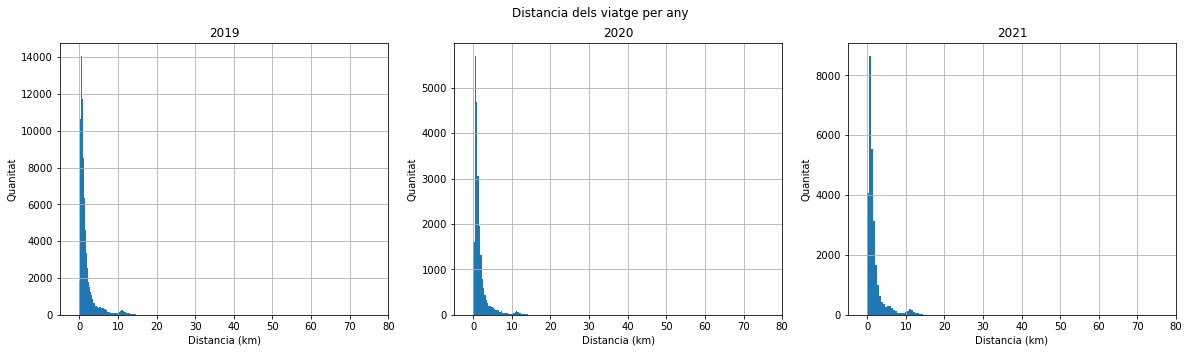

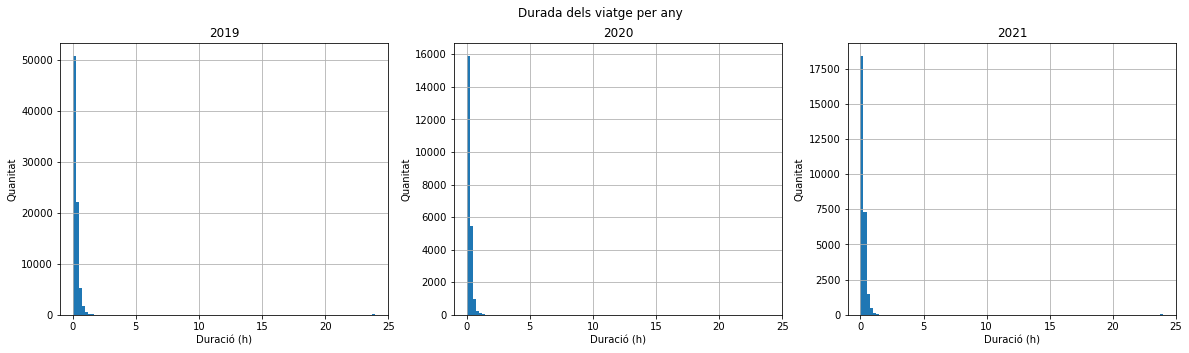

In [228]:
visualize_histograms(df, 'trip_distance', title='Distancia dels viatge per any', xlabel='Distancia (km)', ylabel='Quanitat', xlim=(-5, 80))

visualize_histograms(df, 'trip_duration', title='Durada dels viatge per any', xlabel='Duració (h)', ylabel='Quanitat', xlim=(-1, 25))


**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER

    A partir de les gràfiques podem veure que les distàncies i les durades dels viatges solen ser les mateixes. Amb diferències molt petites, per exemple, el nombre de viatges que hi ha a l'any 2020 amb durada 0.1h i 0.2h ha baixat respecte l'any 2019. Però a 2021 ha tornat a augmentar. Llavors respecte a la velocitat, serà més alta ja que reduim el temps i la durada dels viatges.

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [161]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers=False):
    """
    Funció que mostra un scatter plot donades dues dades
    """
    
    # apliquem la detecció dels valors invàlids amb la funció de facetgrid si cal
    if remove_outliers:
        sea = sns.FacetGrid(df.loc[(df[x_value]< np.percentile(df[x_value],q=50)) & (df[y_value]<np.percentile(df[y_value],q=50))], col='year')
    else:
        sea = sns.FacetGrid(df, col='year')
    
    # mostrem el gràfic de dispersió
    sea.map(sns.regplot, x_value, y_value, line_kws={"color": "red"}).set(xlabel=xlabel, ylabel=ylabel)
    
    sea.fig.set_size_inches(20, 5)  
    sea.fig.suptitle('Distancia (km) / Temps (h)')

    plt.show()



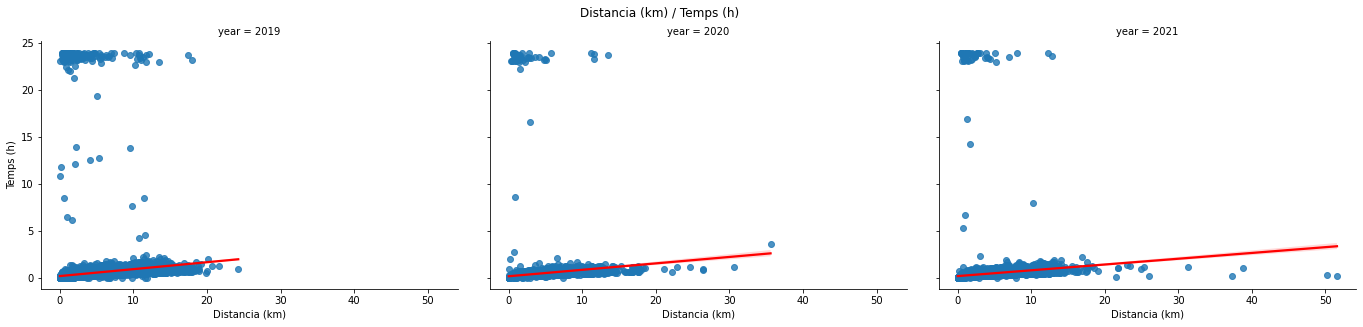

In [162]:
scatter_plot(df, 'trip_distance', 'trip_duration','Distancia (km)', 'Temps (h)')


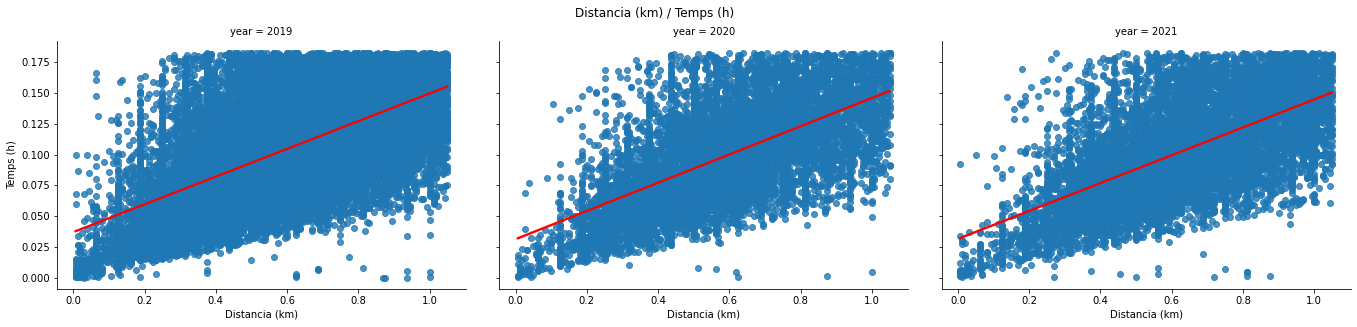

In [163]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)', True)

Tenir en compte que les escales de les dues gràfiques anteriors no són les mateixes, per poder veure més clar les diferències entre els dos tipus de gràfics, podriem configurar perquè es visualitzin en la mateixa escala.

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER 
    
    A partir del gràfic de disperció i correlació podem vuere que, a mesura que augmenta la distància, també augmenta el temps recorregut.

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [164]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """

    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle(title)
    
    # obtenim la mitjana de kms/hores de cada temporada requerida
    for column in range(len(columns)):
        df.groupby([columns[column]]+['year'])[column_data].mean().to_frame().unstack().plot(kind='line', ax=ax[column], style='o:', legend=YEARS, xlabel=xlabel, ylabel=ylabel)


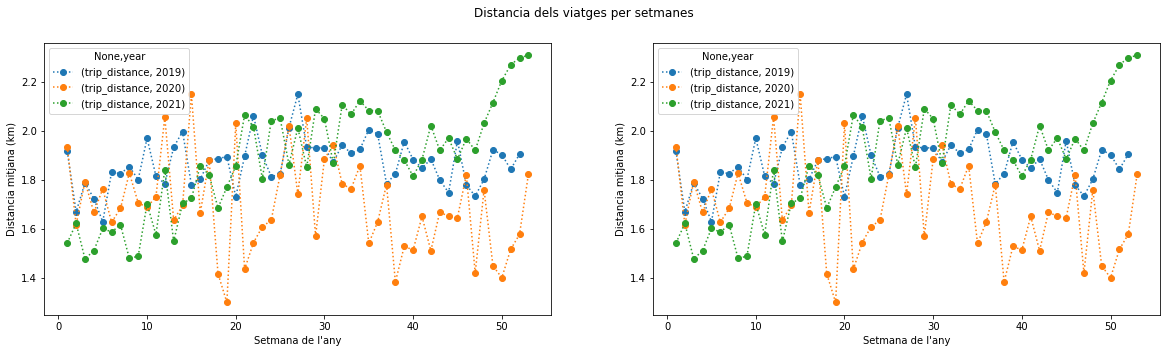

In [165]:
visualize_per_period(df, 'trip_distance', columns=['pickup_week', 'dropoff_week'], xlabel='Setmana de l\'any', ylabel='Distancia mitjana (km)', title='Distancia dels viatges per setmanes')


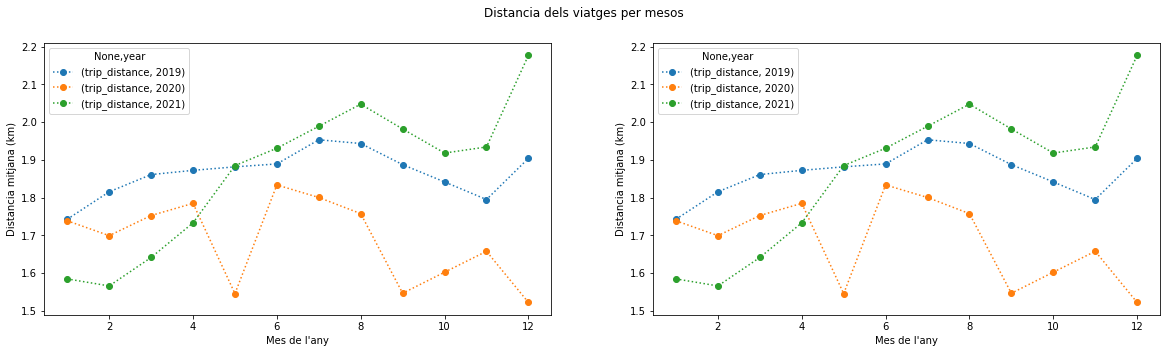

In [166]:
visualize_per_period(df, 'trip_distance', columns=['pickup_month', 'dropoff_month'],xlabel='Mes de l\'any', ylabel='Distancia mitjana (km)', title='Distancia dels viatges per mesos')


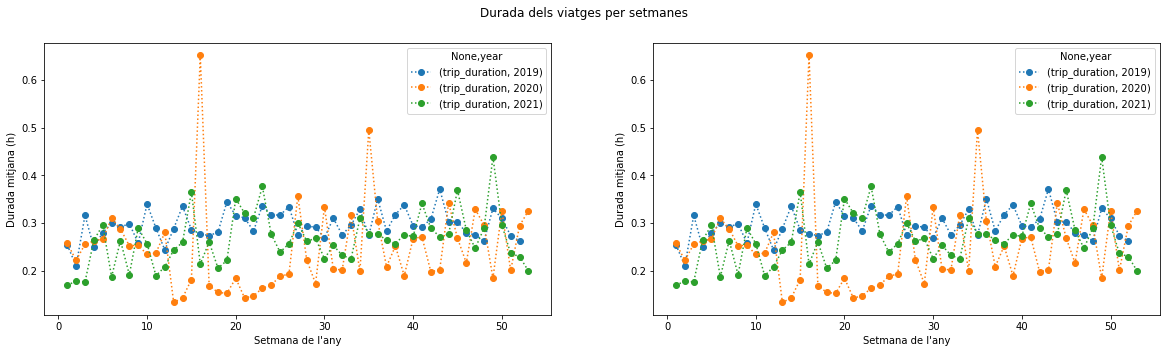

In [167]:
visualize_per_period(df, 'trip_duration', columns=['pickup_week', 'dropoff_week'], xlabel='Setmana de l\'any', ylabel='Durada mitjana (h)', title='Durada dels viatges per setmanes')


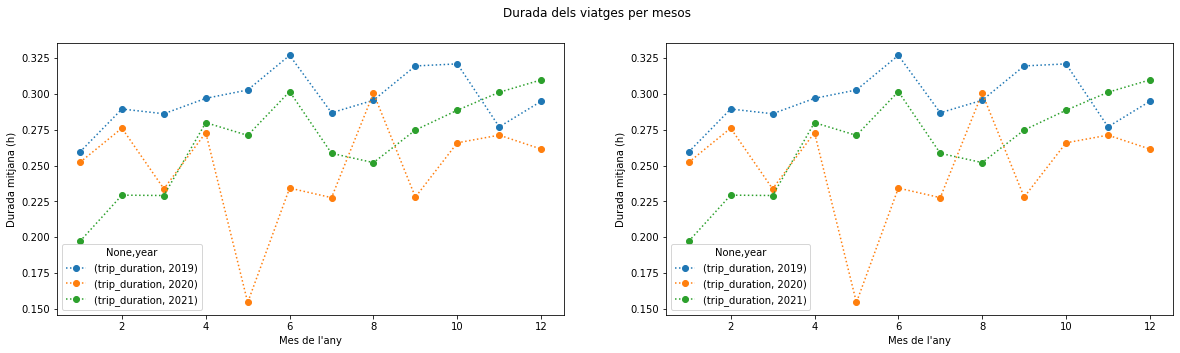

In [168]:
visualize_per_period(df, 'trip_duration', columns=['pickup_month', 'dropoff_month'], xlabel='Mes de l\'any', ylabel='Durada mitjana (h)', title='Durada dels viatges per mesos')


**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER
    
    La distància mitjana a les primeres setmanes de 2020 es manté més o menys igual que els altres dos anys, mentre a la setmana 19, 20 que seria als principis del mes d'abril, aquest nombre baixa de sobte degut a les restriccions que implanta el govern.

    I en la gràfica de la distància de viatges per mesos podem veure que al mes de maig arriba al punt més baix de recorregut mitjà, degut el mateix motiu explicat abans, i ens presenta un decreixement de kms per la resta de mesos de l'any, mentre els anys 2019 i 2020 aquest número va creixent.

    En la gràfica de durada de viatges per setmanes de l'any, vuerem que en la setmana 16,17 hi ha un pic, mentre en la gràfica de durada de viatges per mesos de l'any hi ha una baixada, el motiu possible per la qual succeix aquest comportament pot ser que un cop el govern ha anunciat les restriccions, tothom es desplaça per confinar-se a casa seva, llavors la mitjana d'aquella setmana pot presentar més alt que la resta de setmanes, aleshores, un cop la gent es queda a casa en confinament i ningú surt, llavors, baixa la mitjana del mes. 

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [169]:
def heatmap(df, group, column_data, xlabel, ylabel, columns=None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """
    for year in YEARS:
        # crea una taula com a dataFrame i li introduim les dades requerides
        heatmap = pd.pivot_table(df[df['year'] == year], values = column_data, index=group[0], columns=group[1])  
        plt.subplots(figsize=(20,30))
        plt.title(f"{group[0]} / {group[1]} {year}")
        plt.xlabel(f"{xlabel} {year}")
        plt.ylabel(ylabel)
        # visualitzem les imatges
        plt.imshow(heatmap)
 
    plt.show()  



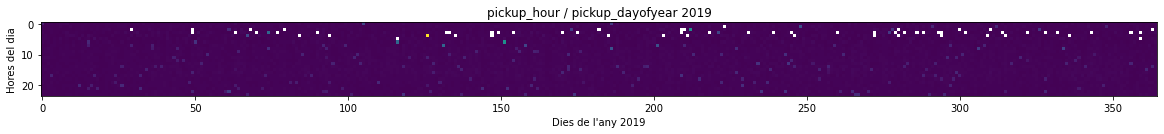

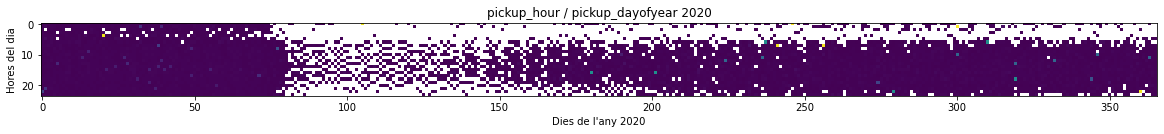

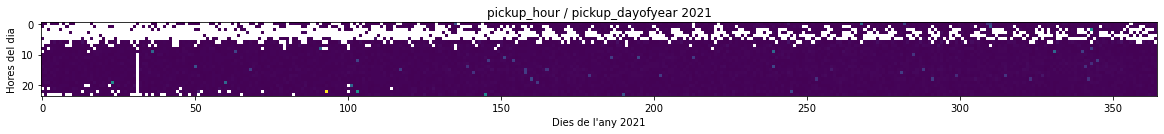

In [170]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')


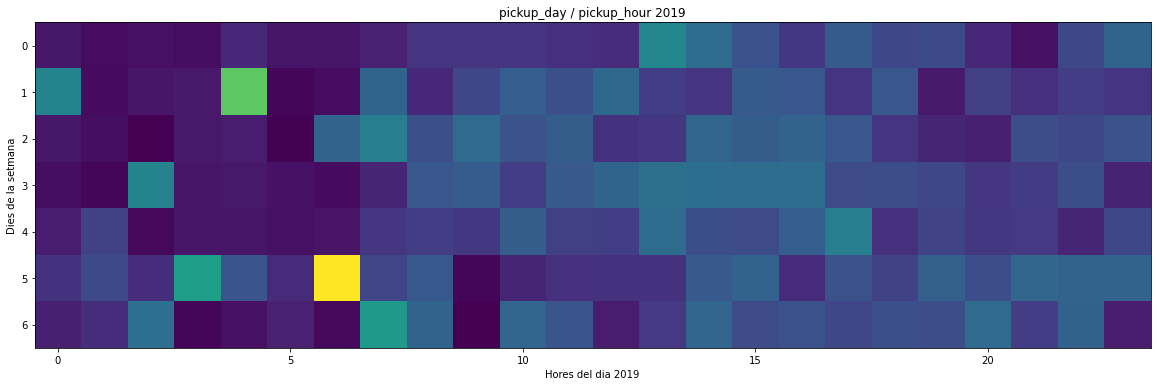

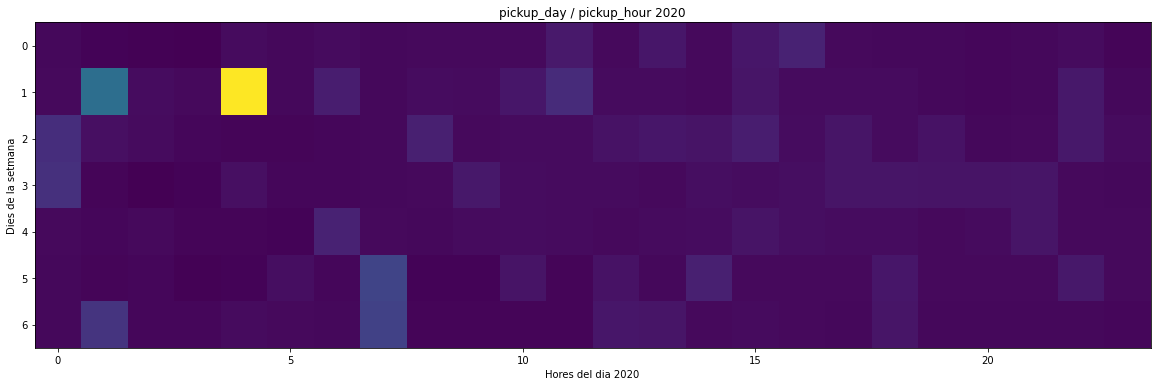

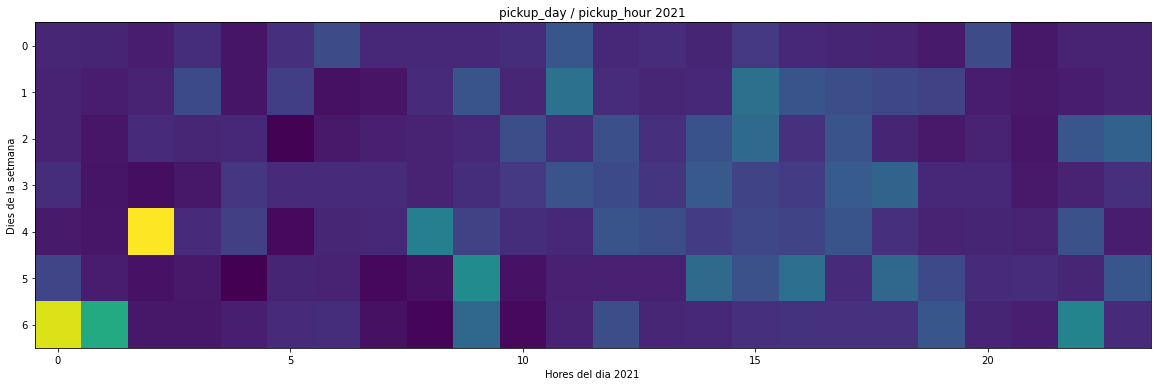

In [171]:
heatmap(df, ['pickup_day', 'pickup_hour'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])



Repeteix els gràfics anteriors visualitzant la distancia.

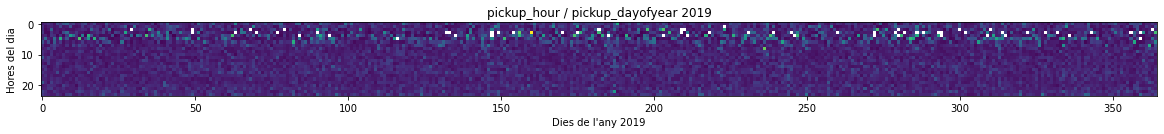

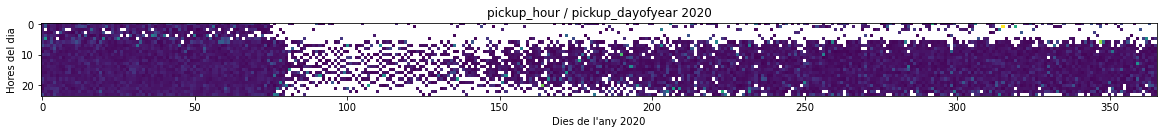

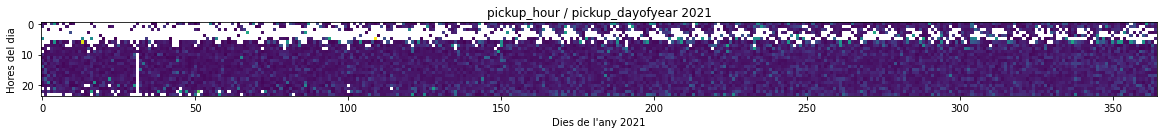

In [172]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'],'trip_distance', 'Dies de l\'any', 'Hores del dia')


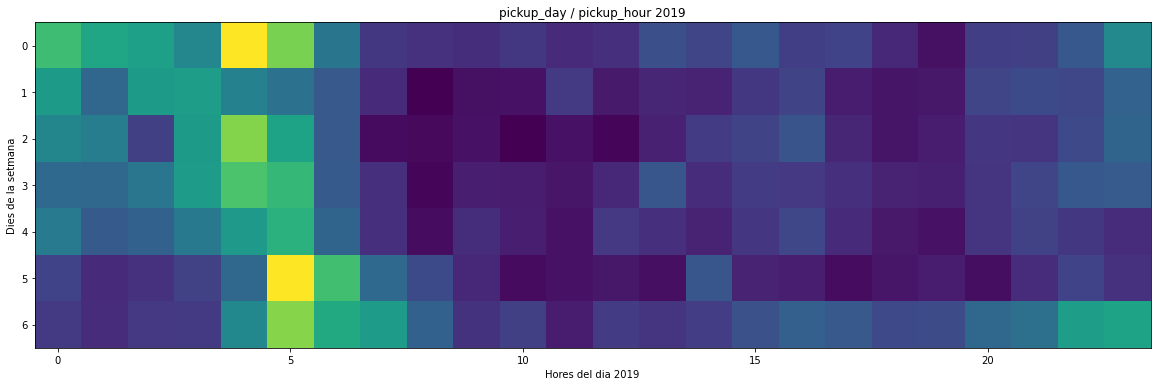

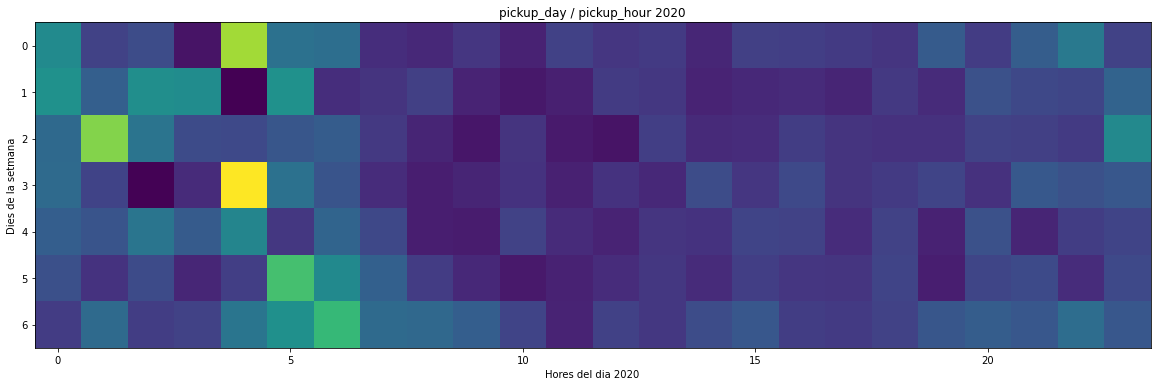

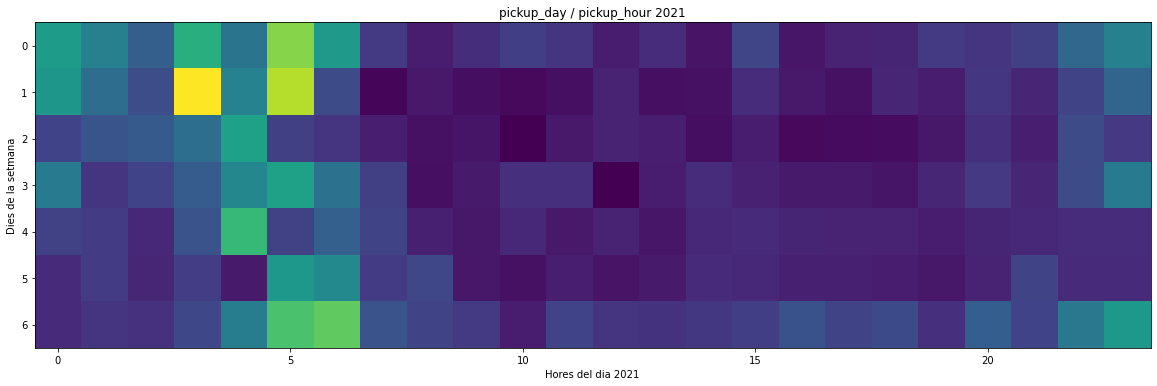

In [173]:
heatmap(df, ['pickup_day', 'pickup_hour'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [178]:
#def heatmap(df, group, column_data, xlabel, ylabel, columns=None):
def speed_heatmap(df, group, xlabel, ylabel, columns=None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """

    fig, ax = plt.subplots(3, 1, figsize=(20,15))
    fig.suptitle(f"velocitat mitjana a les diferents hores del dia durant la setmana")


    for year in range(len(YEARS)):
        heatmap = pd.pivot_table(df[df['year'] == YEARS[year]], values = "mean_speed", index=group[1], columns=group[0])  
        ax[year].imshow(heatmap)
        ax[year].set_title(YEARS[year])
        ax[year].set(xlabel=xlabel, ylabel=ylabel)

    plt.show()

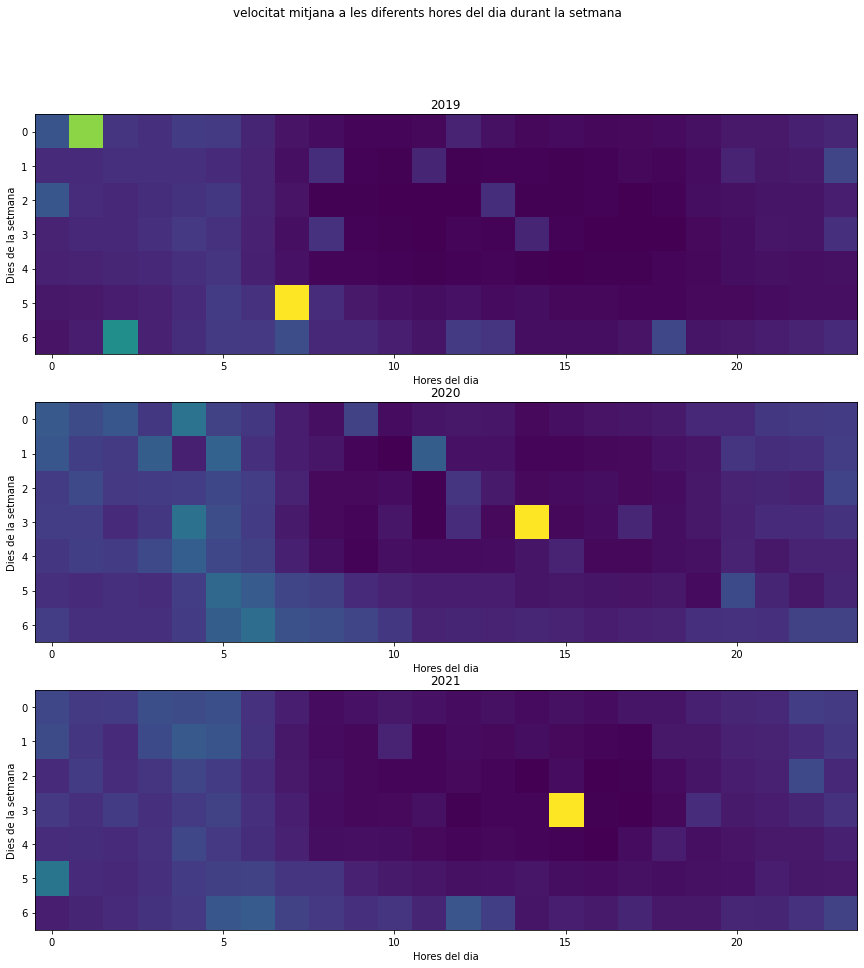

In [179]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER 

    A partir dels mapes de calor de pickup per dies de l'any, veurem que els valors de l'any 2019 tendeixen a ser més uniformes, mentre a 2020 comencen a haver-hi grans diferències a partir dels dies 80, 90. 

    A partir dels mapes de calor de velocitat podem vuere a quines hores de la setmana la velocitat dels viatges són més ràpids. Els resultats que hem obtingut són a les 8 del matí de dissabtes, a les 14 del migdia de dijous, a les 15 del migdia de dijous. En general, la velocitat és més ràpida per les nits.

## 05. Visualitzem les localitzacions dels viatges

In [180]:
df.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,1,1,1,1,0,1,1,1,0.111111,8.437500
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,1,0.135278,8.824435
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,0.87500,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,1,0.140833,6.213018
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.41875,162,137,2,4.0,5.30,2019,...,1,1,1,1,0,1,1,1,0.050000,8.375000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,1.69375,161,262,1,13.5,17.76,2019,...,1,1,1,1,0,1,1,1,0.288611,5.868624


Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [181]:
from utils import get_lat_lon, draw_region_map, draw_zone_map


In [182]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]


In [183]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


c:\Users\JUNJIE_LI\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


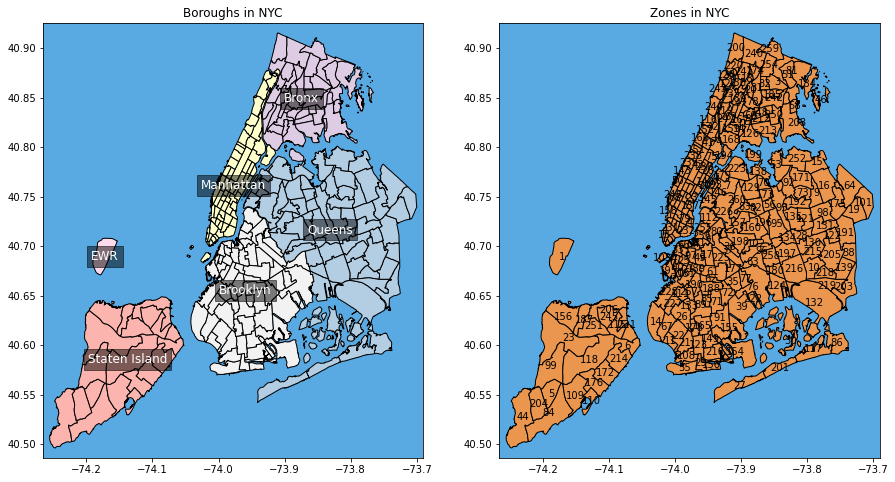

In [184]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)


In [185]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_day,pickup_week,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,1,1,1,1,0,1,1,1,0.111111,8.437500
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,1,0.135278,8.824435
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,0.87500,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,1,0.140833,6.213018
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.41875,162,137,2,4.0,5.30,2019,...,1,1,1,1,0,1,1,1,0.050000,8.375000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,1.69375,161,262,1,13.5,17.76,2019,...,1,1,1,1,0,1,1,1,0.288611,5.868624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106000,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,0.62500,107,170,1,5.5,11.15,2021,...,4,52,12,365,22,4,52,12,0.075833,8.241758
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.02500,211,158,2,9.0,12.80,2021,...,4,52,12,365,22,4,52,12,0.161111,6.362069
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,0.93125,79,164,2,8.0,11.80,2021,...,4,52,12,365,23,4,52,12,0.161389,5.770224
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.56250,263,236,1,5.0,11.00,2021,...,4,52,12,365,23,4,52,12,0.057778,9.735577


Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [187]:
merge = pd.merge(df, df_loc[['LocationID', 'longitude', 'latitude']],how="left", left_on='PULocationID', right_on='LocationID')
merge.rename(columns={'longitude' : 'longitude_PU', 'latitude' : 'latitude_PU'}, inplace = True)
merge.drop('LocationID', axis='columns', inplace=True)

merge = pd.merge(merge, df_loc[['LocationID', 'longitude', 'latitude']], how="left", left_on='DOLocationID', right_on='LocationID')
merge.rename(columns={'longitude' : 'longitude_DO', 'latitude' : 'latitude_DO'}, inplace = True)
merge.drop('LocationID', axis='columns', inplace=True)

merge


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed,longitude_PU,latitude_PU,longitude_DO,latitude_DO
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,0,1,1,1,0.111111,8.437500,-73.968222,40.797859,-73.978732,40.784025
1,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,0.135278,8.824435,-73.990664,40.719102,-73.977172,40.740336
2,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,0.87500,249,164,1,7.5,11.40,2019,...,1,1,1,1,0.140833,6.213018,-74.001965,40.734611,-73.985684,40.749083
3,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.41875,162,137,2,4.0,5.30,2019,...,0,1,1,1,0.050000,8.375000,-73.972471,40.756840,-73.977172,40.740336
4,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,1.69375,161,262,1,13.5,17.76,2019,...,0,1,1,1,0.288611,5.868624,-73.977680,40.758030,-73.945142,40.776681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131548,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,0.62500,107,170,1,5.5,11.15,2021,...,22,4,52,12,0.075833,8.241758,-73.984016,40.737337,-73.977648,40.747725
131549,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.02500,211,158,2,9.0,12.80,2021,...,22,4,52,12,0.161111,6.362069,-74.001082,40.723716,-74.009774,40.735295
131550,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,0.93125,79,164,2,8.0,11.80,2021,...,23,4,52,12,0.161389,5.770224,-73.985315,40.727954,-73.985684,40.749083
131551,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.56250,263,236,1,5.0,11.00,2021,...,23,4,52,12,0.057778,9.735577,-73.951008,40.778766,-73.957010,40.780440


## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [189]:
# Recollida
# AQUÍ EL TEU CODI
df['to_pick_up'] = df['PULocationID'].map(merge['PULocationID'].value_counts())
top_pu = df.sort_values(['to_pick_up','PULocationID']).drop('to_pick_up', axis=1)

# Destí
# AQUÍ EL TEU CODI
df['to_drop_off'] = df['DOLocationID'].map(merge['DOLocationID'].value_counts())
top_do = df.sort_values(['to_drop_off','DOLocationID']).drop('to_drop_off', axis=1)

df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_month,pickup_dayofyear,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed,to_pick_up,to_drop_off
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,1,1,0,1,1,1,0.111111,8.437500,1362,3501
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,0.135278,8.824435,1472,1905
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,0.87500,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,0.140833,6.213018,2572,2662
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.41875,162,137,2,4.0,5.30,2019,...,1,1,0,1,1,1,0.050000,8.375000,4674,1905
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,1.69375,161,262,1,13.5,17.76,2019,...,1,1,0,1,1,1,0.288611,5.868624,5367,1912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106000,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,0.62500,107,170,1,5.5,11.15,2021,...,12,365,22,4,52,12,0.075833,8.241758,3046,4084
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.02500,211,158,2,9.0,12.80,2021,...,12,365,22,4,52,12,0.161111,6.362069,949,1245
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,0.93125,79,164,2,8.0,11.80,2021,...,12,365,23,4,52,12,0.161389,5.770224,3350,2662
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.56250,263,236,1,5.0,11.00,2021,...,12,365,23,4,52,12,0.057778,9.735577,2787,5769


In [190]:
n_top = 5


def show_top_n(df, column, df_loc, n_top=n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    result = pd.merge(df,df_loc, left_on=column, right_on='LocationID').groupby(['year','zone']).count()[column].groupby('year').nlargest(n_top)
    return result


In [191]:
show_top_n(top_pu, 'PULocationID', df_loc)


year  year  zone                        
2019  2019  Upper East Side South           3503
            Midtown Center                  3400
            Upper East Side North           3209
            Midtown East                    2983
            Penn Station/Madison Sq West    2979
2020  2020  Upper East Side South           1100
            Upper East Side North           1073
            Midtown Center                   929
            Midtown East                     799
            Penn Station/Madison Sq West     777
2021  2021  Upper East Side South           1499
            Upper East Side North           1300
            Midtown Center                  1038
            JFK Airport                      974
            Penn Station/Madison Sq West     953
Name: PULocationID, dtype: int64

In [192]:
show_top_n(top_do, 'DOLocationID', df_loc)


year  year  zone                 
2019  2019  Upper East Side North    3400
            Midtown Center           3296
            Upper East Side South    3251
            Murray Hill              2539
            Midtown East             2511
2020  2020  Upper East Side North    1064
            Upper East Side South     949
            Midtown Center            801
            Lenox Hill West           694
            Murray Hill               673
2021  2021  Upper East Side North    1305
            Upper East Side South    1251
            Midtown Center            970
            Murray Hill               872
            Upper West Side South     843
Name: DOLocationID, dtype: int64

**Visualitzem amb un mapa de calor quines són les zones més recurrents**

c:\Users\JUNJIE_LI\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\JUNJIE_LI\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\JUNJIE_LI\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


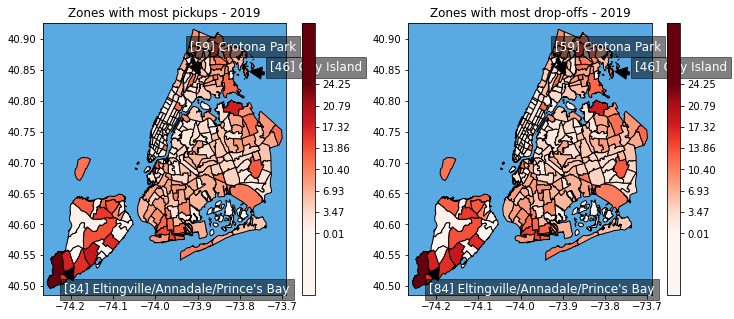

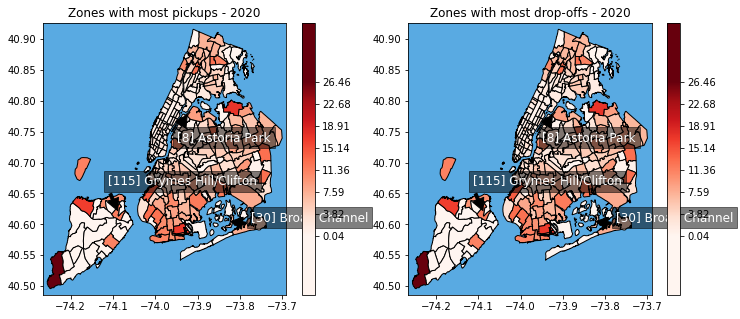

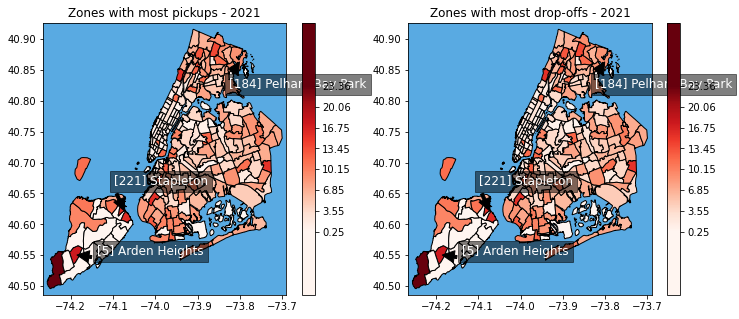

In [193]:
for year in YEARS:
    PUcount = {k: v for k, v in top_do[top_do.year == year][[
        'DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])


**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER

    Perquè Manhattan és el centre de Nova York

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [194]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA',
             '40.710255', '-74.005058'),
             ('Manhattan Gastroenterology, NYC, NY, USA', 
             '40.778259', '-73.958092'),
             ('Stem Cell Therapy Hospital, NYC, NY, USA', 
             '40.601517', '-73.961067'),
             ('Park Avenue Smiles, Yonkers, NYC, NY, USA',
              '40.945873', '-73.890671'),
             ('Cosmetic Dentistry Center, NYC, NY, USA',
              '40.629234', '-74.026077'),
             ('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA',
             '40.607059', '-73.960144'),
             ('VIVA EVE, Forest Hills, NYC, NY, USA',
              '40.734291', '-73.849434'),
             ('Forest Hills Medical Services, Queens, NYC, NY, USA', 
             '40.734310', '-73.849510'),
             ('Professional Gynecological Services, Brooklyn, NY, NY, USA',
             '40.689747', '-73.982346'),
             ('Manhattan Womens Health & Wellness, New York, NY, USA', 
             '40.741997', '-73.986107'),
             ('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', 
             '40.689743', '-73.982368'),
             ('Brooklyn GYN Place, Brooklyn, NY, USA', 
             '40.692696', '-73.993584'),
             ('Americas Holistic Doctor, NYC, NY, USA', 
             '40.742531', '-73.985489'),
             ('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA',
             '40.641621', '-73.956734'),
             ('DHD Medical, Brooklyn New York, USA', 
             '40.625568', '-73.918320'),
             ('Workers Compensation Doctor, New York, NY, USA', 
             '40.652225', '-74.006104'), ]

hospitals = pd.DataFrame(hospitals, columns=['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()


,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [195]:
def scatter_locations(merge, hospitals):
    """
    Funció que mostra la distribució dels hospitals i les destinacions dels taxis
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    data = merge.groupby(['longitude_DO','latitude_DO'])['DOLocationID'].count().reset_index(name='quantity')
    data.plot(kind='scatter', x='longitude_DO', y='latitude_DO', c='cornflowerblue', alpha=0.2, s='quantity',
              title='distribució Hospitals i de taxis', xlabel='Longitude', ylabel='Latitude', ax=ax)
    hospitals.plot.scatter(x='Longitude', y='Latitude', ax=ax, color='red')


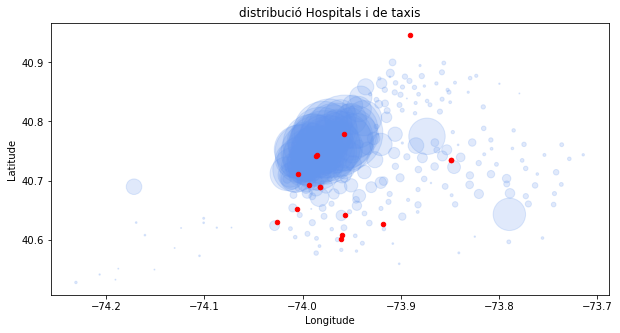

In [196]:
scatter_locations(merge, hospitals)


In [203]:
def scatter_locations_per_year(merge, hospitals):
    """
    Funció que mostra la distribució dels hospitals i les destinacions dels taxis
    """

    fig = plt.figure(figsize=(10,15))
    for year in range(len(YEARS)):
        ax = fig.add_subplot(3, 1, year+1)
        data = merge.loc[merge['year']==YEARS[year]].groupby(['longitude_DO','latitude_DO'])['DOLocationID'].count().reset_index(name='quantity')
        data.plot(kind='scatter', x='longitude_DO', y='latitude_DO', c='cornflowerblue',  alpha=0.2, s='quantity',
                  title="distribució Hospitals i de taxis", xlabel='Longitude',ylabel='Latitude', ax=ax)
        hospitals.plot.scatter(x='Longitude', y='Latitude', ax=ax, color='red')
    plt.show()


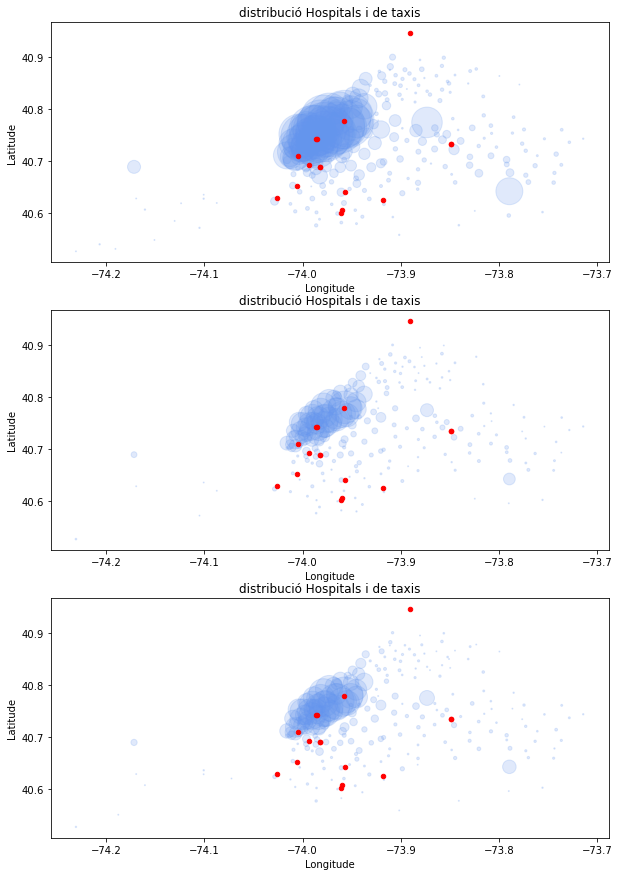

In [204]:
scatter_locations_per_year(merge, hospitals)


**Pregunta: Veus algun comportament?**
>ANSWER

    Es veu molt clar a partir de les gràfiques que la destinació dels viatges a hospitals ha incrementat repsecte a altres destiancions, encara que la concentració de viatges hagi baixat.

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [205]:
from scipy.spatial import distance_matrix


In [206]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values


dist = distance_matrix(hospitals_loc, loc)
dist.shape


(16, 271)

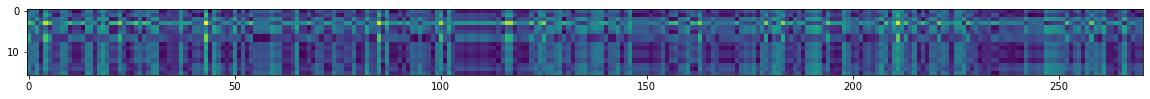

In [207]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)


Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [208]:
# AQUÍ EL TEU CODI
hospitals_locations = dist.argmin(axis=1)
hospitals['LocationID'] = df_loc['LocationID'].unique()[hospitals_locations]


In [209]:
hospitals.head()


,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,220
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,247
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,134
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,211
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,14


Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [ ]:
hospitals

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,220
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,247
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,134
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,211
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,14
5,"Envy Smile Dental Spa, Brooklyn, NYC, NY, USA",40.607059,-73.960144,134
6,"VIVA EVE, Forest Hills, NYC, NY, USA",40.734291,-73.849434,56
7,"Forest Hills Medical Services, Queens, NYC, NY...",40.734310,-73.849510,56
8,"Professional Gynecological Services, Brooklyn,...",40.689747,-73.982346,25
9,"Manhattan Womens Health & Wellness, New York, ...",40.741997,-73.986107,245


In [ ]:
merge

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration,mean_speed,longitude_PU,latitude_PU,longitude_DO,latitude_DO
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,0.93750,151,239,1,7.0,9.95,2019,...,0,1,1,1,0.111111,8.437500,-73.968222,40.797859,-73.978732,40.784025
1,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.19375,148,137,2,8.5,9.80,2019,...,1,1,1,1,0.135278,8.824435,-73.990664,40.719102,-73.977172,40.740336
2,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,0.87500,249,164,1,7.5,11.40,2019,...,1,1,1,1,0.140833,6.213018,-74.001965,40.734611,-73.985684,40.749083
3,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.41875,162,137,2,4.0,5.30,2019,...,0,1,1,1,0.050000,8.375000,-73.972471,40.756840,-73.977172,40.740336
4,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,1.69375,161,262,1,13.5,17.76,2019,...,0,1,1,1,0.288611,5.868624,-73.977680,40.758030,-73.945142,40.776681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131548,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,0.62500,107,170,1,5.5,11.15,2021,...,22,4,52,12,0.075833,8.241758,-73.984016,40.737337,-73.977648,40.747725
131549,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.02500,211,158,2,9.0,12.80,2021,...,22,4,52,12,0.161111,6.362069,-74.001082,40.723716,-74.009774,40.735295
131550,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,0.93125,79,164,2,8.0,11.80,2021,...,23,4,52,12,0.161389,5.770224,-73.985315,40.727954,-73.985684,40.749083
131551,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.56250,263,236,1,5.0,11.00,2021,...,23,4,52,12,0.057778,9.735577,-73.951008,40.778766,-73.957010,40.780440


In [212]:
from matplotlib.pyplot import legend


def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(20,5))

    df[['DOLocationID', 'year']].groupby(['year']).value_counts(sort=False, normalize=False).to_frame()\
    .loc[((YEARS),hospitals_locations),:].unstack(level=0).plot(kind='bar',ax = ax[0], title='quantitat viatges amb destins a hospitals', legend=YEARS)
    
    df[['DOLocationID', 'year']].groupby(['year']).value_counts(sort=False, normalize=True).to_frame()\
    .loc[((YEARS),hospitals_locations),:].unstack(level=0).plot(kind='bar',ax = ax[1], title='% viatges amb destins a hospitals', legend=YEARS)

    plt.show()


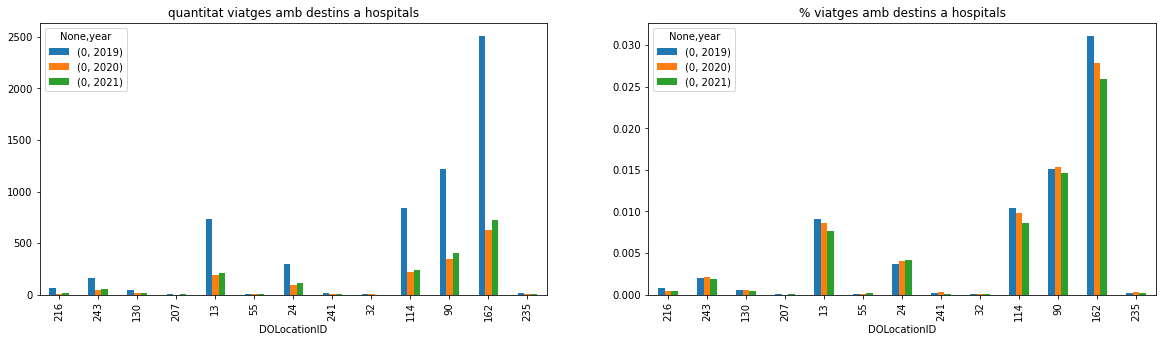

In [213]:
trips_hospitals(df, hospitals_locations)


## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

## Primera part

In [215]:
def get_invalid(data, year, month,sampling = 1000):
    """
    Funció que visualitza totes les dades que hem volgut eliminar
    """
    invalides = data[required_data]
    if sampling != 0:
        invalides = invalides[::sampling]

    # La recollida és després que la finalització del trajecte.
    df1 = invalides[invalides['tpep_dropoff_datetime'] <= invalides['tpep_pickup_datetime']]
    
    # Les dades s'importen per mes i any. Les dates són correctes?
    # extreurem el mes i l'any amb la comanda -> pd.DatetimeIndex(df['birth_date']).year /  pd.DatetimeIndex(df['birth_date']).month
    any_pick = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).year != year
    any_pick_igual = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).year == year
    mes_pick = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).month != month
    mes_pick_igual = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).month == month
    any_drop = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).year == year
    any_drop_igual = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).year != year
    mes_drop = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).month == month
    mes_drop_igual = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).month != month
    # mentre quaslevol d'aquests quatre no coincideixi:
    df2 = invalides[(any_pick & any_drop) | (mes_pick & mes_drop) | (any_pick_igual & any_drop_igual) | (mes_pick_igual & mes_drop_igual)]

    # dades amb menys d'un passatger o més de 9 passatgers
    condicio = invalides['passenger_count'] <= 0
    condicio2 = invalides['passenger_count'] > 9
    df3 = invalides[condicio | condicio2]

    # Viatges molts llargs o molt curts
    viatges_invalids = invalides['trip_distance'] <= 0
    viatges_llargs = invalides['trip_distance'] > 100
    df4 = invalides[viatges_invalids | viatges_llargs]

    # pagaments negatius
    no_pagats = invalides['total_amount'] <= 0
    df5 = invalides[no_pagats]
    
    frames = [df1,df2,df3,df4,df5]
    invalides = pd.concat(frames)
    return invalides

In [ ]:
invalides = pd.concat([get_invalid(load_table(year, month), year, month,0) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])
invalides

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
28,2019-01-01 00:32:59,2019-01-01 00:32:59,3.0,0.00,237,264,2,6.50,7.80
681,2019-01-01 00:39:07,2019-01-01 00:39:07,1.0,0.00,142,264,2,2.50,3.80
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1.0,0.00,186,264,2,0.00,0.00
3661,2019-01-01 00:54:29,2019-01-01 00:54:29,1.0,0.00,249,264,2,2.50,3.80
4573,2019-01-01 00:58:14,2019-01-01 00:58:14,1.0,0.00,158,264,2,33.50,34.80
...,...,...,...,...,...,...,...,...,...
3203328,2021-12-24 19:24:00,2021-12-24 19:25:00,NaN,0.07,163,163,0,-26.80,-20.00
3203837,2021-12-25 06:21:00,2021-12-25 06:34:00,NaN,6.43,74,113,0,-40.52,-31.57
3204366,2021-12-25 14:56:00,2021-12-25 14:58:00,NaN,0.04,87,87,0,-28.81,-21.70
3211118,2021-12-30 01:13:46,2021-12-30 01:14:47,NaN,0.03,230,230,0,-28.93,-21.80


-De les primeres línies, podem vuere que són invàlides perquè la distància recorreguda és 0 i a més perquè el temps de dropoff coincideix amb el temps de pickup, a part podem vuere que el valor del total_amount és 0.

-Les últimes línies que ens mostra no s'ha grabat correctament el nombre de passatgers en el taxi, llavors també les considerem invàlides, a part d'això, també podem observar que als total_amount són números negatius, la qual també ens indica que es tracta de dades invalides.


In [216]:
any_pick = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).year != 2020
any_drop = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).year == 2020
# mentre quaslevol d'aquests quatre no coincideixi:
df1 = invalides[any_pick & any_drop]
df1

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
4449188,2019-12-31 16:56:40,2020-01-01 00:04:10,1.0,0.98,100,234,2,6.0,10.30
6677776,2019-12-31 00:30:29,2020-01-01 00:20:14,1.0,2.23,43,163,2,8.5,12.30
6678255,2019-12-31 00:53:06,2020-01-01 00:35:45,5.0,4.20,43,7,1,14.5,21.96
6678398,2019-12-31 00:57:14,2020-01-01 00:30:22,1.0,1.10,48,50,1,5.5,10.70
6679487,2019-12-31 00:16:28,2020-01-01 00:03:29,2.0,1.05,186,230,1,6.0,11.76
...,...,...,...,...,...,...,...,...,...
58319,2019-12-31 16:14:49,2020-01-01 15:24:15,1.0,1.57,261,144,1,8.5,13.30
65522,2019-12-31 15:59:29,2020-01-01 15:31:22,1.0,16.17,164,132,1,45.5,50.80
65523,2019-12-31 16:11:56,2020-01-01 15:21:19,1.0,1.99,68,107,1,9.0,14.51
556110,2021-01-15 07:27:40,2020-10-13 12:03:02,1.0,1.60,161,234,1,9.0,13.30


Tampoc hem considerat aquests casos en les quals el temps de pickup i dropoff no pertany al mateix any o mes.

In [217]:
# dades amb menys d'un passatger o més de 9 passatgers
condicio2 = invalides['passenger_count'] > 9
df2 = invalides[condicio2]
df2

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
57956,2021-08-01 19:47:43,2021-08-01 19:57:54,112.0,1.80,79,234,1,9.0,14.76
171072,2021-08-03 11:51:58,2021-08-03 12:09:29,96.0,1.56,100,137,1,11.5,17.02


Tampoc hem considerat els viatges que tenen un nombre de passatgers exagerat

In [218]:
viatges_invalids = invalides['trip_distance'] < 0
df3 = invalides[viatges_invalids]
df3

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
6878088,2019-11-30 23:49:00,2019-12-01 00:12:00,NaN,-5.02,50,232,0,14.81,21.11
6878101,2019-11-30 23:15:00,2019-12-01 00:00:00,NaN,-10.50,50,102,0,45.65,49.20
4641728,2019-11-20 16:51:31,2019-11-20 17:51:56,1.0,-11.45,45,74,2,39.59,39.59
4650415,2019-11-20 16:13:00,2019-11-20 16:38:15,1.0,-4.69,155,35,2,47.80,48.60
4663082,2019-11-20 17:06:09,2019-11-20 18:37:19,1.0,-14.42,79,215,1,50.16,50.16
...,...,...,...,...,...,...,...,...,...
6378673,2020-01-15 22:34:00,2020-01-15 23:00:00,NaN,-6.55,232,72,0,35.95,39.50
6378683,2020-01-15 22:10:00,2020-01-15 23:01:00,NaN,-23.03,48,55,0,46.51,56.18
6358072,2020-01-08 15:08:10,2020-01-08 15:10:00,NaN,-0.01,75,75,0,-36.04,-35.24
6358074,2020-01-08 15:08:10,2020-01-08 15:10:00,NaN,-0.01,75,75,0,-36.04,-35.24


Les línies amb una distància negativa o igual a 0 seran eliminades

In [219]:
viatges_llargs = invalides['trip_distance'] > 1000
df4 = invalides[viatges_llargs]
df4

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
3133914,2019-06-14 10:53:40,2019-06-14 10:54:57,1.0,45977.22,193,193,2,0.00,0.00
3133914,2019-06-14 10:53:40,2019-06-14 10:54:57,1.0,45977.22,193,193,2,0.00,0.00
704581,2019-12-04 10:20:13,2019-12-04 10:24:43,1.0,19130.18,224,224,2,11.00,11.00
6397623,2020-01-28 07:37:00,2020-01-28 08:42:00,NaN,210240.07,76,231,0,37.77,41.32
6254657,2020-02-04 06:56:00,2020-02-04 07:56:00,NaN,50769.78,29,87,0,35.46,45.13
...,...,...,...,...,...,...,...,...,...
3207316,2021-12-27 13:27:00,2021-12-27 13:38:00,NaN,59694.97,66,13,0,13.20,20.05
3211141,2021-12-30 03:52:00,2021-12-30 04:05:00,NaN,118228.10,151,161,0,17.41,25.20
3211348,2021-12-30 08:11:00,2021-12-30 08:58:00,NaN,100281.62,165,86,0,51.30,57.30
3213507,2021-12-31 15:45:00,2021-12-31 16:06:00,NaN,65380.00,211,265,0,30.25,49.10


També hi han viatges amb una distància massa llarga, aquests no estarn inclosos.

## Segona part

Recompte del tipus de pagament dels pasatgers:

In [220]:
def passengers_payment(df, column, payment_dict, title):
    """
    Funció que visualitza quin és el tipus de pagament que sol fer servir els passatgers
    """
    taula_any = df
    figure = plt.figure(figsize=(20,20))
    
    for index,year in enumerate(YEARS):
        # agafem només les dades de l'any corresponent
        taula_any = df[df['year'] == year]
        # obtenim el recompte de tipus de pagament
        serie = taula_any.groupby(column).size()
        
        figure.add_subplot(3,1,(index+1))
        payment_names = [payment_dict[i] for i in serie.index]
        colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
        
        plt.pie(serie, autopct='%.1f%%', labels = payment_names, labeldistance=2, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },colors=colors);
       
        plt.title(title + str(year))
        plt.legend()

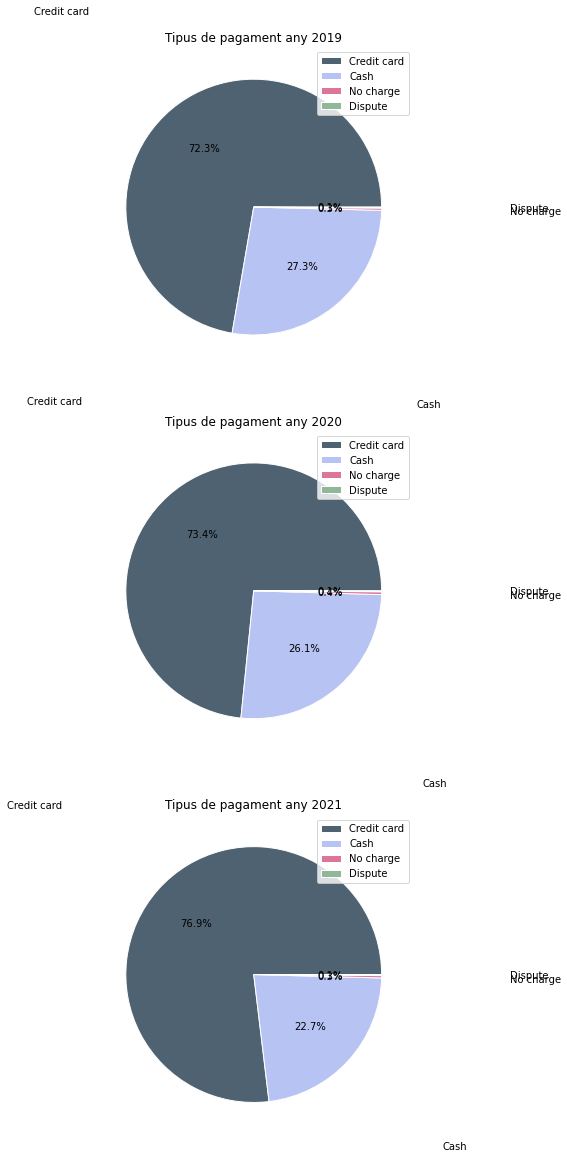

In [221]:
passengers_payment(df, 'payment_type', {1: "Credit card", 2: "Cash", 3: "No charge", 4: "Dispute", 5: "Unknown", 6: "Voided trip"},"Tipus de pagament any ")

De les gràfiques circulars mostrades sobre el pagament del viatges, podem veure que en tots els anys, la majoria de la gent tendeix a pagar o amb tarjeta o en efectiu.

## 09. Informe



    La crisi causada per la pandèmia de la COVID ha comportat enormes impactes i canvis socials, econòmics, afectant tots els aspectes de les nostres vides. Resulta un gran repte per la societat a enfrontar-se a aquesta situació sanitària degut a què la implantació de certes restriccions per poder controlar la propagació del virus suposarà també un impacte enorme en el món laboral. Un exemple seria, el mercat de taxis. Per entendre, quantificar i conèixer millor els impactes de la covid a aquest sector, explorarem i analitzarem les dades recollides de 3 anys seguides: des de l'any anterior de l'esclat de la pandèmia fins un any després d'alleujar confinaments i restriccions. Estudiarem els viatges realitzats amb els taxis grocs de la ciutat de Nova York durant aquests 3 anys. Observarem com ha canviat la covid l'ús dels taxis, els canvis presentats en aquests dos períodes veient com varia per exemple, la distància, la durada dels viatges, el nombre de passatgers que van al taxi, els horaris més usuals, les zones on més o menys taxis s'agafen, els dies de les setmanes, el mes que més s'agafen... I d'aquesta forma veure des de diferents punts de vista com està afectant. 

    Respecte a la quantiat de viatges vuerem que hi ha una gran diferència abans i després de l'esclat de covid. A causa de les restriccions governamentals o les prohibicions a la mobilitat humana, la gent es veu obligat a treballar des de casa i els estudiants atenen classes en línia, de manera que la demanda de viatges es redueix significativament.

    Així com les distàncies mitjanes recorregudes i temps de durada mitjana a l'any 2020 és una mica més baix que els altres dos anys. Mentre que la majoria del hàbits, com per exemple, els horaris usuals que s'agafen, o les zones freqüent de desplaçament segueixen sent més o menys les mateixes.

    A part d'aixó podem observar que la majoria dels trajectes dels taxistes són en destinació als hospitals, més encara en les zones on hi ha més densitat de població, com poden ser Brooklyn i Queens. Podem notar una quantitat més elevada en 2019 comparada als anys 2020 i 2021, aixó pot ser degut per diverses raóns com poden ser la delinquencia, els tiroteigs, etc i al arribar la pandemia, amb les mesures de seguretat, la població ha sigut obligada a romandre en quarentena fent que només s'atengues als hospitals per casos de coronavirus.
    